<a href="https://colab.research.google.com/github/teddiclax/Stochastic_Simulation_Of_Styrene_FRP/blob/teddiclax/Stochastic_Simulation_Of_Styrene_FRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### IMPORT NECESSARY LIBRARIES FOR THE SIMULATION
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
%matplotlib inline
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, RateRule, \
                      AssignmentRule, FunctionDefinition
from gillespy2 import TauLeapingCSolver
from gillespy2 import TauHybridCSolver
from gillespy2 import ODECSolver
from gillespy2 import ODESolver
from gillespy2 import SSACSolver
print(gillespy2.__version__)

1.8.2


In [3]:
### DEFINING THE PARAMETERS AND PROGRAM CODE :
## Defining the operating temperature (T) and input parameters such as Monomer(M), Solvent(S) and Initiator(I) in degrees kelvin (K) and moles per litres (Mol/L) respectively.
M0=104.15; # Molecular weight of Styrene as monomer(M0) in mol/dm3
S0=92.14;  # Molecular weight of Toluene as solvent(S0) in mol/dm3
I0=242.23; # Molecular weight of Benzoyl Peroxide as initiator(I0) in mol/dm3
v=4*10**(-3);  # Reactor's volume in litres (L)
T=(140+273.15); # Operating temperature in degrees Kelvin(K)
R= 8.3145; # Universal Gas Constant(J.mol^-1.K^-1)

## Pre-defining the kinetic parameters we have:
f= 89.91*math.exp(-14240/(T*R));
k_d = 1.0272*10**(17)*math.exp(-15924/(T))/f;
k_i = 0;
k_p = 1.051*10**(7)*math.exp(-3577/(T));
k_p_2 =4*1.051*10**(7)*math.exp(-3577/(T));
k_trM= 3.110*10**(3)*math.exp(-5631/(T));
k_trS= 1.968*10**(4)*math.exp(-6302/(T));
k_iterm =1.99*10**(6)*math.exp(-14842/(T));
k_t = 1.255*10**(9)*math.exp(-844/(T));
k_td = 1*k_t;
k_tc = 0*k_t;


##Developing the Model using Gillepsy2
class StyrenePolymerization(Model):
    def __init__(self, MAX_N = 25,volume = v):
        #
        Model.__init__(self, name="StyrenePolymerization")


        # Set System Volume
        Model.volume = 0.004
        # First, choose a maximum value for the states
        max_state = MAX_N
        print(f"Creating Styrene Polymerization model, MAX_N={MAX_N}")
        # Creating Species for all states as well as variables

        self.add_species(Species(name="I", initial_value=int(1/(I0*0.001)), mode="discrete"))
        self.add_species(Species(name="S", initial_value=int(59/(S0*0.001)), mode="discrete"))
        self.add_species(Species(name="M", initial_value=int(41/(M0*0.001)), mode="discrete"))
        self.add_species(Species(name="R", initial_value=0, mode="discrete"))
        self.add_species(Species(name="D", initial_value=0, mode="discrete"))
        self.add_species(Species(name="d", initial_value=0, mode="discrete"))

        for n in range(1,MAX_N):
          self.add_species(Species(name=f"P{n}", initial_value=0, mode="discrete"))

        # Inputting Kinetic Parameters
        self.add_parameter(Parameter(name="k_d",    expression= k_d))
        self.add_parameter(Parameter(name="k_i",    expression= k_i))
        self.add_parameter(Parameter(name="k_iterm",expression= k_iterm))
        self.add_parameter(Parameter(name="k_p",    expression= k_p))
        self.add_parameter(Parameter(name="k_p_2",    expression= k_p_2))
        self.add_parameter(Parameter(name="k_trM",   expression= k_trM))
        self.add_parameter(Parameter(name="k_trS",   expression= k_trS))
        self.add_parameter(Parameter(name="k_td", expression= k_td))
        self.add_parameter(Parameter(name="k_tc",   expression= k_tc ))
        self.add_parameter(Parameter(name="k_t",   expression= k_t ))

        # INITIATION REACTION (Chemical Initiation)
        self.add_reaction(Reaction(reactants={'I':1},
                                   products={'R':2},
                                   rate=self.listOfParameters["k_d"]))
        self.add_reaction(Reaction(reactants={'R':1,'M':1},
                                   products={'P1':1},
                                   rate=self.listOfParameters["k_p_2"]))

        # INTIATION REACTION (Thermal Initiation)
        self.add_reaction(Reaction(reactants={'M':3},
                                   products={'R':2},
                                   propensity_function="k_iterm*M*(M-1)*(M-2)"))
        self.add_reaction(Reaction(reactants={'R':1,'M':1},
                                   products={'P2':1},
                                   rate=self.listOfParameters["k_p_2"]))
        self.add_reaction(Reaction(reactants={'P1':1,'M':1},
                                   products={'P3':1},
                                   rate=self.listOfParameters["k_p_2"]))
       # PROPAGATION: P_n + M => P_{n+1}
        for n in range(1,max_state-1):
            np1 = n+1
            self.add_reaction(Reaction(reactants={f"P{n}":1,'M':1},
                                products={f"P{np1}": 1},
                                rate=self.listOfParameters["k_p"]))

        # CHAIN TERMINATION BY RECOMBINATION AND DISPROPORTIONATION
        for n in range(1,max_state):
            for m in range(1,max_state):
                nm = n+m
                if( nm < max_state ):
                    if(n==m):
                        self.add_reaction(Reaction(
                                reactants={f"P{n}":1,f"P{m}":1},
                                products={"D":1},
                                rate=self.listOfParameters["k_tc"]))
                    else:
                        self.add_reaction(Reaction(
                                reactants={f"P{n}":1,f"P{m}":1},
                                products={"D":2},
                                rate=self.listOfParameters["k_td"]))

        # CHAIN TRANSFER to MONOMER :
        for n in range(1,max_state):
            np1 = n+1
            self.add_reaction(Reaction(reactants={f"P{n}":1,'M':1},
                                products={"d":1,"P1":1},
                                rate=self.listOfParameters["k_trM"]))
        # CHAIN TRANSFER to SOLVENT :
        for n in range(1,max_state):
            np1 = n+1
            self.add_reaction(Reaction(reactants={f"P{n}":1,'S':1},
                                products={"d":1,"P1":1},
                                rate=self.listOfParameters["k_trS"]))




        # Timespan: 0 -> 30 minutes
        self.timespan(np.arange(0,1800,1))

In [4]:
### INITIALIZING MODEL() :
model = StyrenePolymerization()
S_RESULT = model.run(solver=TauLeapingCSolver,number_of_trajectories=100)
#S_RESULT = model.run(solver=TauHybridCSolver,number_of_trajectories=100,tau_step=1e-5,tau_tol=0.01)
#S_RESULT = model.run(solver=SSACSolver,number_of_trajectories=3)
s_result_2 = model.run(solver=SSACSolver,number_of_trajectories=3)
#s_result_2 = model.run(solver=TauHybridCSolver,number_of_trajectories=3,tau_tol=0.01)
s_result_11 = model.run(solver=SSACSolver,number_of_trajectories=1)
s_result_22 = model.run(solver=SSACSolver,number_of_trajectories=1)
s_result_33 = model.run(solver=SSACSolver,number_of_trajectories=1)
solver = gillespy2.ODESolver(model=model)
d_result = solver.run(integrator='lsoda')

Creating Styrene Polymerization model, MAX_N=25


In [5]:
s_result=S_RESULT.average_ensemble()

In [6]:
### COMPUTATION OF THE MONOMER CONSUMPTION RATE: X
X_deterministic=((d_result['M'][0]-d_result['M'][-1])/d_result['M'][0]);
X_stochastic=((s_result['M'][0]-s_result['M'][-1])/s_result['M'][0]);
print(X_deterministic)
print(X_stochastic)

0.9552244404664534
0.3925190839694656


In [8]:
### COMPUTATION OF THE MOLECULAR WEIGHT DISTRIBUTION (DETERMINISTIC AND STOCHASTIC): MN,MW AND PDI
Mw=104.15; # Molecular weight of styrene monomer in g/mol
md=np.sum(d_result['M']);
dd=np.sum(d_result['d']);
Dd=np.sum(d_result['D']);
B_Sd=1-(Dd/(md+dd));
B_Sd;

## Computing the molecular weight distribution of the polymer for the deterministic trajectories.

mn_D=Mw*(2/(1-B_Sd));  # Average Number Molecular Weight (Mn)
mw_D=Mw*((2+B_Sd)/(1-B_Sd));  # Average Weight Molecular Weight (Mw)
pd_D=(mw_D/mn_D); # Polydispersity Or Heterogeneity Index (PDI)
ms=np.sum(s_result['M']);
ds=np.sum(s_result['d']);
Ds=np.sum(s_result['D']);
B_Ss=1-(Ds/(ms+ds));
B_Ss;
mn_S=Mw*(2/(1-B_Ss));
mw_S=Mw*((2+B_Ss)/(1-B_Ss));
pd_S=(mw_S/mn_S);
print((mn_D))
print((mn_S))
print(mw_D)
print(mw_S)
print(pd_D)
print(pd_S)

1257.330483484775
1664.7286826287934
1781.8457252271626
2392.9430239431904
1.4171657719525408
1.4374372526365466


In [9]:
Mw=104.15; # Molecular weight of styrene monomer in g/mol
## Computing the graphical output for  moldecular weight distridution of the polymer - X, Mn, Mw and PDI
m_d=np.array(d_result['M']);
d_d=np.array(d_result['d']);
D_d=np.array(d_result['D']);
B_Sd=1-(D_d/(m_d+d_d));
mn_D=Mw*(2/(1-B_Sd));
mw_D=Mw*((2+B_Sd)/(1-B_Sd));
pd_D=(mw_D/mn_D);
m_s=np.array(s_result['M']);
d_s=np.array(s_result['d']);
D_s=np.array(s_result['D']);
B_Ss=1-(D_s/(m_s+d_s));
mn_S=Mw*(2/(1-B_Ss));
mw_S=Mw*((2+B_Ss)/(1-B_Ss));
pd_S=(mw_S/mn_S);
m_s_2=np.array(s_result_2['M']);
d_s_2=np.array(s_result_2['d']);
D_s_2=np.array(s_result_2['D']);
B_Ss_2=1-(D_s_2/(m_s_2+d_s_2));
mn_S_2=Mw*(2/(1-B_Ss_2));
mw_S_2=Mw*((2+B_Ss_2)/(1-B_Ss_2));
pd_S_2=(mw_S_2/mn_S_2);
##############################################
m_s_11=np.array(s_result_11['M']);
d_s_11=np.array(s_result_11['d']);
D_s_11=np.array(s_result_11['D']);
B_Ss_11=1-(D_s_11/(m_s_11+d_s_11));
mn_S_11=Mw*(2/(1-B_Ss_11));
mw_S_11=Mw*((2+B_Ss_11)/(1-B_Ss_11));
pd_S_11=(mw_S_11/mn_S_11);
m_s_22=np.array(s_result_22['M']);
d_s_22=np.array(s_result_22['d']);
D_s_22=np.array(s_result_22['D']);
B_Ss_22=1-(D_s_22/(m_s_22+d_s_22));
mn_S_22=Mw*(2/(1-B_Ss_22));
mw_S_22=Mw*((2+B_Ss_22)/(1-B_Ss_22));
pd_S_22=(mw_S_22/mn_S_22);
m_s_33=np.array(s_result_33['M']);
d_s_33=np.array(s_result_33['d']);
D_s_33=np.array(s_result_33['D']);
B_Ss_33=1-(D_s_33/(m_s_33+d_s_33));
mn_S_33=Mw*(2/(1-B_Ss_33));
mw_S_33=Mw*((2+B_Ss_33)/(1-B_Ss_33));
pd_S_33=(mw_S_33/mn_S_33);
warnings.filterwarnings(action='ignore',category=RuntimeWarning)

<ipython-input-9-3418af6d5902>:6: RuntimeWarning: divide by zero encountered in divide
  mn_D=Mw*(2/(1-B_Sd));
<ipython-input-9-3418af6d5902>:7: RuntimeWarning: divide by zero encountered in divide
  mw_D=Mw*((2+B_Sd)/(1-B_Sd));
<ipython-input-9-3418af6d5902>:8: RuntimeWarning: invalid value encountered in divide
  pd_D=(mw_D/mn_D);
<ipython-input-9-3418af6d5902>:13: RuntimeWarning: divide by zero encountered in divide
  mn_S=Mw*(2/(1-B_Ss));
<ipython-input-9-3418af6d5902>:14: RuntimeWarning: divide by zero encountered in divide
  mw_S=Mw*((2+B_Ss)/(1-B_Ss));
<ipython-input-9-3418af6d5902>:15: RuntimeWarning: invalid value encountered in divide
  pd_S=(mw_S/mn_S);
2024-05-28 14:43:57,783 - GillesPy2 - WARNING - Results is of type list. Use results[i]['M'] instead of results['M']
2024-05-28 14:43:57,785 - GillesPy2 - WARNING - Results is of type list. Use results[i]['d'] instead of results['d']
2024-05-28 14:43:57,786 - GillesPy2 - WARNING - Results is of type list. Use results[i]['D'] 

In [76]:
# Removing the "nan" in the array.
pd_D = np.array(pd_D)
pd_D_no_nan = np.nan_to_num(pd_D, nan=0)
PDI_std = np.std(pd_D_no_nan)

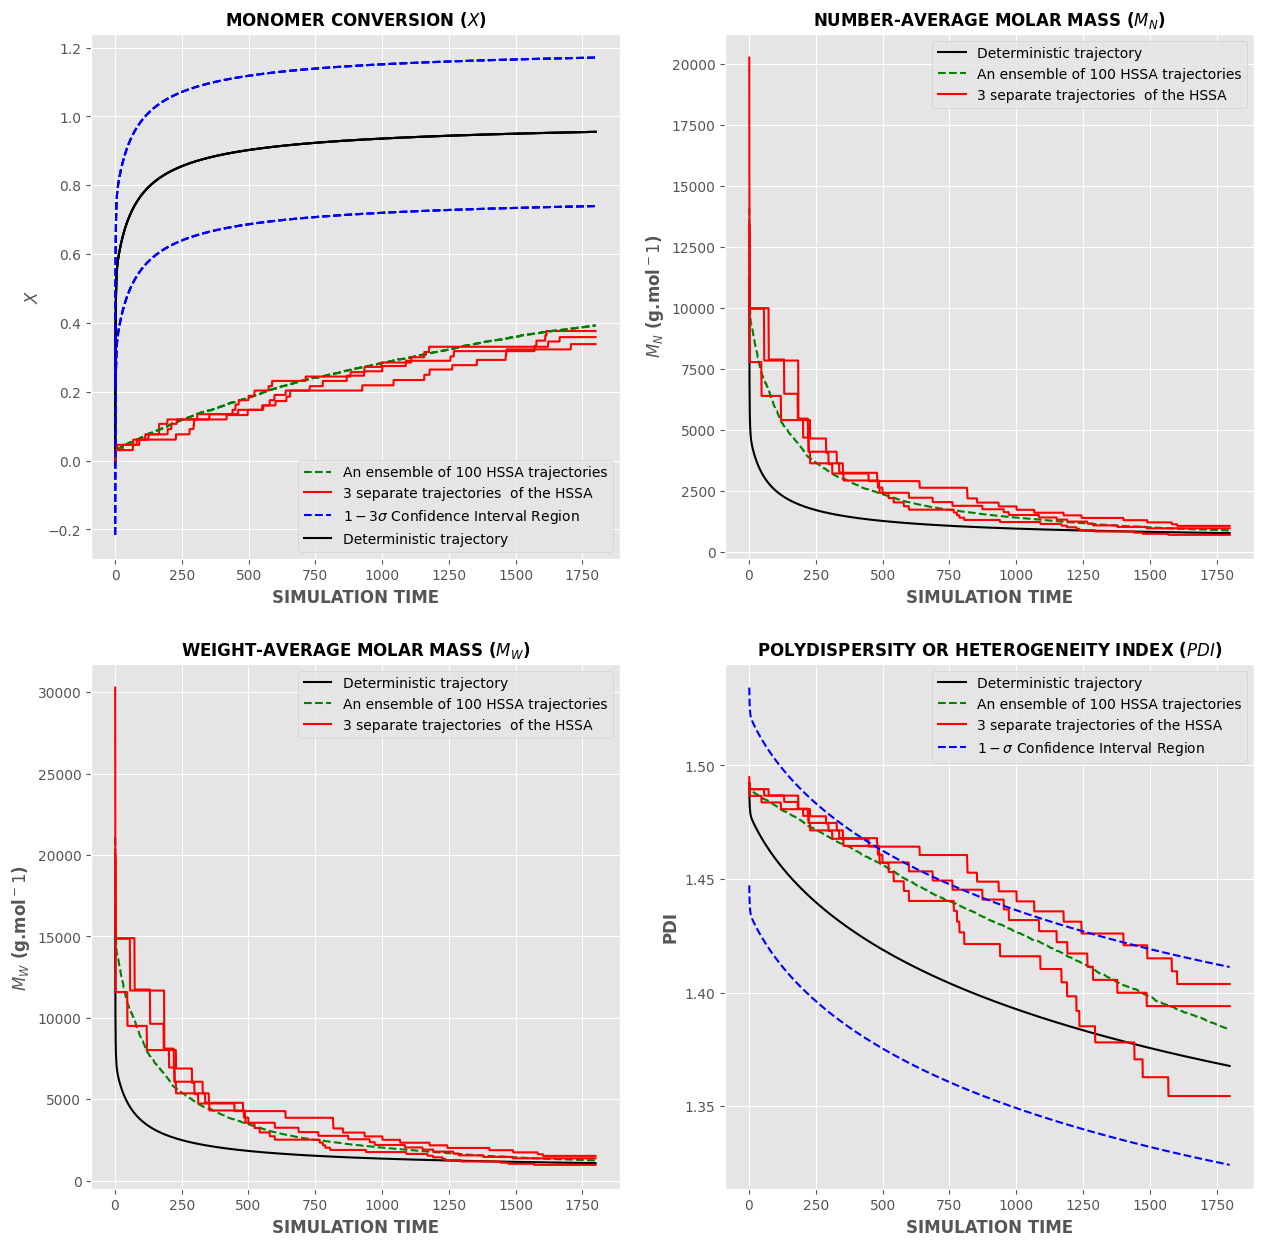

In [79]:
### GRAPHICAL PLOT OF RESULTS FOR MONOMER CONVERSION AND MOLECULAR MASS (WEIGHT) DISTRIBUTION OF THE POLYSTYRENE. ###
### GRAPHICAL PLOT OF RESULTS ###
plt.figure(figsize = (15, 15))
plt.rcParams["axes.labelweight"]="bold"
plt.style.use('ggplot')
fontsize=12
Mm=104.15
plt.subplot(221)
MAX_N=25
for index in range(0, len(s_result)):
  p_stochastic = s_result[index]
  d_trajectory = d_result
  p_stochastic=((p_stochastic['M'][0]-p_stochastic['M'][:])/p_stochastic['M'][0])
for index_2 in range(0, len(s_result_2)):
  p_stochastic_2 = s_result_2[index_2]
  p_stochastic_2=((p_stochastic_2['M'][0]-p_stochastic_2['M'][:])/p_stochastic_2['M'][0])
  p_deterministic=((d_result['M'][0]-d_result['M'][:])/d_result['M'][0])
  plt.plot(d_trajectory['time'],p_deterministic, 'k',label="Deterministic trajectory")
  plt.plot(s_result[index]['time'],p_stochastic , 'g--',label="An ensemble of 100 HSSA trajectories")
  plt.plot(s_result_2[index_2]['time'],p_stochastic_2 , 'r',label="3 separate trajectories  of the HSSA")
  x_mean=p_deterministic.mean()
  x_std =p_deterministic.std()
  plt.plot(d_trajectory['time'],p_deterministic-3*(x_std), 'b--',label="$1-3{\sigma}$ Confidence Interval Region")
  plt.plot(d_trajectory['time'],p_deterministic+3*(x_std),'b--')
plt.legend(["Deterministic trajectory","An ensemble of 100 HSSA trajectories","3 separate trajectories  of the HSSA"],loc="lower right")
plt.title('MONOMER CONVERSION ($X$)',fontsize=fontsize,weight='bold')
plt.xlabel('SIMULATION TIME',fontsize=fontsize,weight='bold')
plt.ylabel("$X$",fontsize=fontsize,weight='bold')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.subplot(222)
MAX_N=25
Mn_deterministic=mn_D
for index in range(0, len(s_result)):
  Mn_stochastic=s_result[index]
  Mn_stochastic=mn_S
Mn_stochastic11=mn_S_11
Mn_stochastic22=mn_S_22
Mn_stochastic33=mn_S_33
plt.plot(d_result['time'],Mn_deterministic, 'k',label="Deterministic trajectory")
plt.plot(s_result['time'],Mn_stochastic , 'g--',label="An ensemble of 100 HSSA trajectories")
plt.plot(s_result_11['time'],Mn_stochastic11 , 'r',label="3 separate trajectories  of the HSSA")
plt.plot(s_result_22['time'],Mn_stochastic22, 'r')
plt.plot(s_result_33['time'],Mn_stochastic33, 'r')
plt.xlabel('SIMULATION TIME',fontsize=fontsize,weight='bold')
plt.ylabel('$M_{N}$ (g.mol${^-1}$)',fontsize=fontsize,weight='bold')
plt.title("NUMBER-AVERAGE MOLAR MASS ($M_{N}$)",fontsize=fontsize,weight='bold')
plt.legend(["Deterministic trajectory","An ensemble of 100 HSSA trajectories","3 separate trajectories  of the HSSA"],loc="upper right")
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,2,3]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


plt.subplot(223)
MAX_N=25
Mw_deterministic=mw_D
for index in range(0, len(s_result)):
  Mw_stochastic=s_result[index]
  Mw_stochastic=mw_S
Mw_stochastic11=mw_S_11
Mw_stochastic22=mw_S_22
Mw_stochastic33=mw_S_33
plt.plot(d_result['time'],Mw_deterministic, 'k',label="Deterministic trajectory")
plt.plot(s_result['time'],Mw_stochastic , 'g--',label="An ensemble of 100 HSSA trajectories")
plt.plot(s_result_11['time'],Mw_stochastic11 , 'r',label="3 separate trajectories  of the HSSA")
plt.plot(s_result_22['time'],Mw_stochastic22, 'r')
plt.plot(s_result_33['time'],Mw_stochastic33, 'r')
plt.xlabel('SIMULATION TIME',fontsize=fontsize,weight='bold')
plt.ylabel("$M_{W}$ (g.mol${^-1}$) ",fontsize=fontsize,weight='bold')
plt.title('WEIGHT-AVERAGE MOLAR MASS ($M_{W}$)',fontsize=fontsize,weight='bold')
plt.legend(["Deterministic trajectory","An ensemble of 100 HSSA trajectories","3 separate trajectories  of the HSSA"],loc="upper right")
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,2,3]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10)


plt.subplot(224)
MAX_N=25
PDI_deterministic=pd_D
for index in range(0, len(s_result)):
  PDI_stochastic=s_result[index]
  PDI_stochastic=pd_S
  PDI_stochastic11=pd_S_11
  PDI_stochastic22=pd_S_22
  PDI_stochastic33=pd_S_33
  plt.plot(d_result['time'],PDI_deterministic, 'k',label="Deterministic trajectory")
  plt.plot(s_result['time'],PDI_stochastic , 'g--',label="An ensemble of 100 HSSA trajectories")
  plt.plot(s_result_11['time'],PDI_stochastic11 , 'r',label="3 separate trajectories  of the HSSA")
  plt.plot(d_trajectory['time'],PDI_deterministic-PDI_std, 'b--',label="$1-{\sigma}$ Confidence Interval Region")
  plt.plot(s_result_22['time'],PDI_stochastic22, 'r')
  plt.plot(s_result_33['time'],PDI_stochastic33, 'r')
plt.plot(d_trajectory['time'],PDI_deterministic+PDI_std,'b--')
plt.xlabel('SIMULATION TIME',fontsize=fontsize,weight='bold')
plt.ylabel('PDI',fontsize=fontsize,weight='bold')
plt.title("POLYDISPERSITY OR HETEROGENEITY INDEX ($PDI$)",fontsize=fontsize,weight='bold')
plt.legend(["Deterministic trajectory","An ensemble of 100 HSSA trajectories","3 separate trajectories of the HSSA","$1-{\sigma}$ Confidence Interval Region"],loc="upper right")
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,4]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10)
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,2,3]

plt.savefig("FRP_GRAPH_1_1.png", dpi=400)
plt.show()
# Remember to remove plt.show()
# import tikzplotlib
# tikzplotlib.save("FRPgraph_3_2.tex")
# OR
# tikzplotlib.save("FRPgraph.tex", flavor="context")
# tikzplotlib.save("FRPgraph.tex")